# Using U-Net for Image Segmentation.
## Using the 2018 Data Bowl dataset

U-nets are great for segmenting medical images.

The researchers who implemented it, and the paper:

U-Net: Convolutional Networks for Biomedical Image Segmentation
Olaf Ronneberger, Philipp Fischer, Thomas Brox
https://arxiv.org/abs/1505.04597



In [26]:
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

print(tf.__version__)
print("GPU available: ", tf.test.is_gpu_available())

print(tf.config.list_physical_devices('GPU'))

# print("GPU available: ", tf.config.list_physical_devices('GPU'))

2.1.0
GPU available:  True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Get the data

2018 Data Science Bowl
Find the nuclei in divergent images to advance medical discovery
This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

https://www.kaggle.com/account/login?returnUrl=%2Fc%2Fdata-science-bowl-2018%2Frules%3Fcontinue%3Ddata

In [2]:
#Specify image data parameters:
INPUT_HEIGHT= 128
INPUT_WIDTH = 128
INPUT_CHANNELS =3

PATH = "..\data\data-science-bowl-2018"

train_folder =os.path.join(PATH,'stage1_train')
test_folder =os.path.join(PATH,'stage1_test')

print(train_folder)
print(test_folder)


..\data\data-science-bowl-2018\stage1_train
..\data\data-science-bowl-2018\stage1_test


In [3]:
def get_image_and_format(fname):
    img = plt.imread(fname)
#     Convert 2d to nxnx1
    img = np.expand_dims(img,axis=-1)
    
    #Resize
    img = tf.image.resize(img,[INPUT_HEIGHT,INPUT_WIDTH])

    img = img.numpy().astype(np.bool)
    return img
    

def get_im_array(foldername, is_training = True):
    # Create the X_train and Y_train from the data folder
    list_im_folder = os.listdir(foldername)

    #Get the number of training images
    num_images_all = len(list_im_folder)

    X_array = np.zeros((num_images_all, INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNELS), dtype=np.float32)
    Y_array = np.zeros((num_images_all, INPUT_HEIGHT,INPUT_WIDTH,1), dtype=np.float32)



    # # Try a single image
    # folder = list_im_folder[0]
    # filepath = os.path.join(train_folder, folder,"images","{}.png".format(folder))
    # print(filepath)
    # img = plt.imread(filepath)
    # print(img.shape, type(img))

    # img = tf.image.resize(img,[INPUT_HEIGHT,INPUT_WIDTH])

    # print(type(img))
    # plt.imshow(img)

    idx=0
    for folder in tqdm(list_im_folder):
    # for folder in list_im_folder[:10]:
        filepath = os.path.join(foldername, folder,"images","{}.png".format(folder))
        img = plt.imread(filepath)[:,:,:3]

        #     #Resize
        img = tf.image.resize(img,[INPUT_HEIGHT,INPUT_WIDTH])

        #Add to array
        X_array[idx] = img

        #Increment
        idx +=1
    

    if(is_training):        
        # For Y_Train, there are multiple masks that need to be combined into 1 mask.
        idx=0
        # folder = list_im_folder[0]
        for folder in tqdm(list_im_folder):
        # for folder in list_im_folder[0:3]:

            mask_folder = os.path.join(foldername, folder,"masks")
            mask_img = None
            for fname_mask in os.listdir(mask_folder):
                filepath_fname_mask = os.path.join(mask_folder, fname_mask)
                if mask_img is None:
                    mask_img =get_image_and_format(filepath_fname_mask)


                img =get_image_and_format(filepath_fname_mask)
                mask_img = np.bitwise_or(img,mask_img)

            # Set this mask_img to Y_train
            Y_array[idx] = mask_img

        #     plt.figure()
        # #     plt.imshow(mask_img[:,:,0])
        #     plt.imshow(Y_Train_full[idx][:,:,0])
            #Increment
            idx+=1

    return X_array,Y_array

X_Train_full, Y_Train_full = get_im_array(train_folder)
print("Shape of X_train_full: {}".format(X_Train_full.shape))
print("Shape of Y_train_full: {}".format(Y_Train_full.shape))
num_train_all = X_Train_full.shape[0]

X_Test, Y_Test = get_im_array(test_folder,is_training=False)
print("Shape of X_test_full: {}".format(X_Test.shape))
print("Shape of Y_test_full: {}".format(Y_Test.shape))
    
#Get the number of test images
num_test_all = X_Test.shape[0]
    

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:35<00:00,  6.98it/s]


Shape of X_train_full: (670, 128, 128, 3)
Shape of Y_train_full: (670, 128, 128, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 57.98it/s]


Shape of X_test_full: (65, 128, 128, 3)
Shape of Y_test_full: (65, 128, 128, 1)


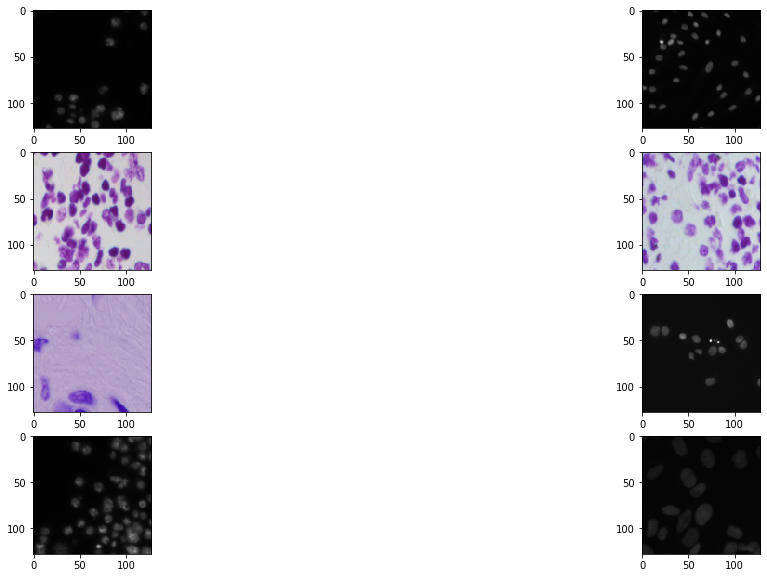

In [4]:
# Plot a few of the X_train_full images for testing only
plt.figure(figsize=(20,10))
rows=4
cols=2

for ii in range(8):
    plt.subplot(rows,cols,ii+1)
    plt.imshow(X_Train_full[ii])

Text(0.5, 0.98, 'Y_Train_full')

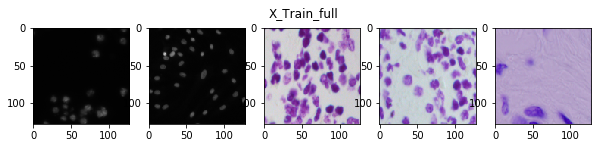

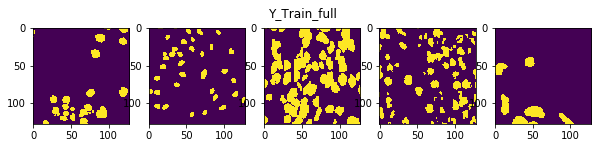

In [5]:
# Plot a few of the X_train_full images for testing only
rows=1
cols=5

plt.figure(figsize=(10,2))
for ii in range(cols):
    plt.subplot(rows,cols,ii+1)
    plt.imshow(X_Train_full[ii])
plt.suptitle('X_Train_full')

plt.figure(figsize=(10,2))
for ii in range(cols):
    plt.subplot(rows,cols,ii+1)
    plt.imshow(Y_Train_full[ii][:,:,0])
plt.suptitle('Y_Train_full')


# print(X_Train_full[0])
# # Plot a few of the Y_train_full images for testing only
# plt.figure(figsize=(20,10))
# rows=4
# cols=4

# for ii in range(4):
#     plt.subplot(rows,cols,ii+1)
#     plt.imshow(Y_Train_full[ii])


Text(0.5, 1.0, 'U-Net architecture')

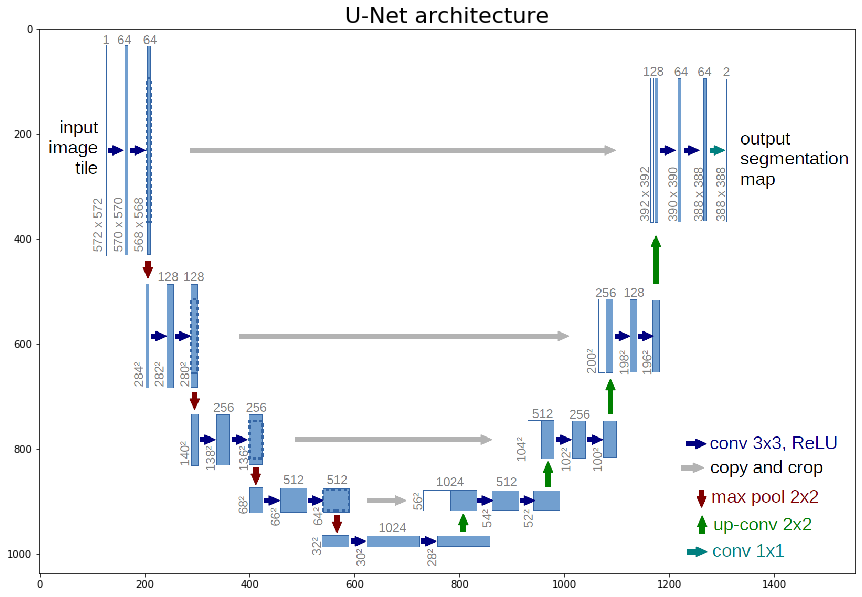

In [6]:
#Show the structure
img = plt.imread("../images/u-net-architecture.png")

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.title("U-Net architecture", fontsize=22)

More details
For my use case, I might modify the sizes a little bit. Maybe use a 256x256 grayscale image size. For the current implementation, the size will depend on the input size of the images.

In [10]:
DROPOUT_FRACTION =0.1

# Build the model using the functional API
def build_UNET():
    #Encoder part
    #Block 1
    input_ = keras.layers.Input(shape=(INPUT_WIDTH,INPUT_WIDTH,INPUT_CHANNELS))
    c1 = keras.layers.Conv2D(16,kernel_size=(3,3),activation='relu',padding='same')(input_)
    c1 = keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(c1)

    #Block 2
    p1 = keras.layers.MaxPool2D((2,2))(c1)
    p1 = keras.layers.Dropout(DROPOUT_FRACTION)(p1)
    c2 = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(p1)
    c2 = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(c2)

    #Block 3
    p2 = keras.layers.MaxPool2D((2,2))(c2)
    p2 = keras.layers.Dropout(DROPOUT_FRACTION)(p2)
    c3 = keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(p2)
    c3 = keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(c3)

    #Block 4
    p3 = keras.layers.MaxPool2D((2,2))(c3)
    p3 = keras.layers.Dropout(DROPOUT_FRACTION)(p3)
    c4 = keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(p3)
    c4 = keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(c4)

    #Block 5
    p4 = keras.layers.MaxPool2D((2,2))(c4)
    p4 = keras.layers.Dropout(DROPOUT_FRACTION)(p4)
    c5 = keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(p4)
    c5 = keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(c5)

    #Decoder part

    #Block 6
    u1 = keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2),activation='relu',padding='same')(c5)
    u1 = keras.layers.concatenate([c4, u1])
    c6 = keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(u1)
    c6 = keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(c6)

    #Block 7
    u2 = keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), activation='relu',padding='same')(c6)
    u2 = keras.layers.concatenate([c3,u2])
    c7 = keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(u2)
    c7 = keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(c7)

    #Block 8
    u3 = keras.layers.Conv2DTranspose(32,(3,3), strides=(2,2), activation='relu',padding='same')(c7)
    u3 = keras.layers.concatenate([c2,u3])
    c8 = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(u3)
    c8 = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(c8)

    #Block 9
    u4 = keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), activation='relu',padding='same')(c8)
    u4 = keras.layers.concatenate([c1,u4])
    c9 = keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(u4)
    c9 = keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(c9)

    #Final layer
#     c10 = keras.layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(c9)
    c10 = keras.layers.Conv2D(1,(3,3),activation=None,padding='same')(c9)

    outputs = c10

    model = keras.Model(inputs=[input_],outputs=[outputs], name='U-Net')
    
    
    return model


In [11]:

model_folder_name = "unet_nucleii_segmentation"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.path.abspath(os.pardir),"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()

#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


ModelCheckpoint Callback saves the model in: C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\unet_nucleii_segmentation\unet_nucleii_segmentation.h5
Tensorboard parent logs folder: ..\models\unet_nucleii_segmentation\tensorboard\my_logs
Current logdir: ..\models\unet_nucleii_segmentation\tensorboard\my_logs\run_2020_03_10_06_26_37


## Dice Loss 

In [30]:
# Create Dice loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

smooth =1.0

In [34]:
model = build_UNET()

model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 128, 128, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_94[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_95[0][0]                  
______________________________________________________________________________________________

In [39]:
EPOCHS  = 100
BATCH_SIZE = 16

#Compile the model
model.compile(optimizer='adam',
             loss =keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy',dice_coef_loss])

model.fit(X_Train_full, Y_Train_full,
          batch_size= BATCH_SIZE,
          epochs =EPOCHS,
          validation_split=0.1,
          shuffle = True,
         callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])


Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - ETA: 56s - loss: 0.0691 - accuracy: 0.9721 - dice_coef_loss: 0.97 - ETA: 28s - loss: 0.0836 - accuracy: 0.9675 - dice_coef_loss: 0.98 - ETA: 19s - loss: 0.0846 - accuracy: 0.9663 - dice_coef_loss: 0.99 - ETA: 11s - loss: 0.0854 - accuracy: 0.9666 - dice_coef_loss: 0.98 - ETA: 9s - loss: 0.0854 - accuracy: 0.9667 - dice_coef_loss: 0.9863 - ETA: 7s - loss: 0.0839 - accuracy: 0.9667 - dice_coef_loss: 0.986 - ETA: 5s - loss: 0.0949 - accuracy: 0.9614 - dice_coef_loss: 0.986 - ETA: 4s - loss: 0.0969 - accuracy: 0.9609 - dice_coef_loss: 0.984 - ETA: 3s - loss: 0.0956 - accuracy: 0.9621 - dice_coef_loss: 0.982 - ETA: 3s - loss: 0.0938 - accuracy: 0.9628 - dice_coef_loss: 0.982 - ETA: 2s - loss: 0.0914 - accuracy: 0.9636 - dice_coef_loss: 0.983 - ETA: 2s - loss: 0.0897 - accuracy: 0.9644 - dice_coef_loss: 0.983 - ETA: 1s - loss: 0.0878 - accuracy: 0.9650 - dice_coef_loss: 0.983 - ETA: 1s - loss:

603/603 [==============================] - ETA: 1s - loss: 0.0770 - accuracy: 0.9668 - dice_coef_loss: 0.976 - ETA: 1s - loss: 0.0862 - accuracy: 0.9657 - dice_coef_loss: 0.981 - ETA: 1s - loss: 0.0864 - accuracy: 0.9654 - dice_coef_loss: 0.982 - ETA: 1s - loss: 0.0810 - accuracy: 0.9672 - dice_coef_loss: 0.983 - ETA: 1s - loss: 0.0775 - accuracy: 0.9685 - dice_coef_loss: 0.984 - ETA: 1s - loss: 0.0748 - accuracy: 0.9696 - dice_coef_loss: 0.984 - ETA: 1s - loss: 0.0716 - accuracy: 0.9710 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0700 - accuracy: 0.9715 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0695 - accuracy: 0.9715 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0682 - accuracy: 0.9720 - dice_coef_loss: 0.986 - ETA: 0s - loss: 0.0683 - accuracy: 0.9721 - dice_coef_loss: 0.986 - ETA: 0s - loss: 0.0699 - accuracy: 0.9714 - dice_coef_loss: 0.986 - ETA: 0s - loss: 0.0712 - accuracy: 0.9709 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0702 - accuracy: 0.9714 - dice_coef_loss: 0.985 - ETA: 

603/603 [==============================] - ETA: 1s - loss: 0.0530 - accuracy: 0.9733 - dice_coef_loss: 0.990 - ETA: 1s - loss: 0.0579 - accuracy: 0.9739 - dice_coef_loss: 0.992 - ETA: 1s - loss: 0.0566 - accuracy: 0.9754 - dice_coef_loss: 0.990 - ETA: 1s - loss: 0.0578 - accuracy: 0.9754 - dice_coef_loss: 0.987 - ETA: 1s - loss: 0.0619 - accuracy: 0.9743 - dice_coef_loss: 0.984 - ETA: 1s - loss: 0.0609 - accuracy: 0.9748 - dice_coef_loss: 0.984 - ETA: 1s - loss: 0.0646 - accuracy: 0.9730 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0641 - accuracy: 0.9732 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0646 - accuracy: 0.9730 - dice_coef_loss: 0.984 - ETA: 0s - loss: 0.0639 - accuracy: 0.9732 - dice_coef_loss: 0.984 - ETA: 0s - loss: 0.0626 - accuracy: 0.9739 - dice_coef_loss: 0.984 - ETA: 0s - loss: 0.0660 - accuracy: 0.9728 - dice_coef_loss: 0.983 - ETA: 0s - loss: 0.0654 - accuracy: 0.9730 - dice_coef_loss: 0.984 - ETA: 0s - loss: 0.0663 - accuracy: 0.9727 - dice_coef_loss: 0.983 - ETA: 

603/603 [==============================] - ETA: 1s - loss: 0.0665 - accuracy: 0.9745 - dice_coef_loss: 0.984 - ETA: 1s - loss: 0.0528 - accuracy: 0.9788 - dice_coef_loss: 0.985 - ETA: 1s - loss: 0.0584 - accuracy: 0.9761 - dice_coef_loss: 0.983 - ETA: 1s - loss: 0.0641 - accuracy: 0.9737 - dice_coef_loss: 0.980 - ETA: 1s - loss: 0.0652 - accuracy: 0.9725 - dice_coef_loss: 0.981 - ETA: 1s - loss: 0.0638 - accuracy: 0.9729 - dice_coef_loss: 0.982 - ETA: 1s - loss: 0.0642 - accuracy: 0.9729 - dice_coef_loss: 0.982 - ETA: 0s - loss: 0.0672 - accuracy: 0.9720 - dice_coef_loss: 0.982 - ETA: 0s - loss: 0.0676 - accuracy: 0.9716 - dice_coef_loss: 0.983 - ETA: 0s - loss: 0.0663 - accuracy: 0.9721 - dice_coef_loss: 0.983 - ETA: 0s - loss: 0.0671 - accuracy: 0.9716 - dice_coef_loss: 0.983 - ETA: 0s - loss: 0.0677 - accuracy: 0.9714 - dice_coef_loss: 0.982 - ETA: 0s - loss: 0.0675 - accuracy: 0.9719 - dice_coef_loss: 0.982 - ETA: 0s - loss: 0.0667 - accuracy: 0.9724 - dice_coef_loss: 0.983 - ETA: 

603/603 [==============================] - ETA: 1s - loss: 0.0554 - accuracy: 0.9757 - dice_coef_loss: 0.987 - ETA: 1s - loss: 0.0547 - accuracy: 0.9756 - dice_coef_loss: 0.985 - ETA: 1s - loss: 0.0557 - accuracy: 0.9758 - dice_coef_loss: 0.983 - ETA: 1s - loss: 0.0532 - accuracy: 0.9771 - dice_coef_loss: 0.983 - ETA: 1s - loss: 0.0578 - accuracy: 0.9753 - dice_coef_loss: 0.984 - ETA: 1s - loss: 0.0583 - accuracy: 0.9751 - dice_coef_loss: 0.985 - ETA: 1s - loss: 0.0591 - accuracy: 0.9747 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0579 - accuracy: 0.9753 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0578 - accuracy: 0.9754 - dice_coef_loss: 0.986 - ETA: 0s - loss: 0.0580 - accuracy: 0.9753 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0585 - accuracy: 0.9751 - dice_coef_loss: 0.985 - ETA: 0s - loss: 0.0582 - accuracy: 0.9754 - dice_coef_loss: 0.984 - ETA: 0s - loss: 0.0589 - accuracy: 0.9751 - dice_coef_loss: 0.984 - ETA: 0s - loss: 0.0627 - accuracy: 0.9739 - dice_coef_loss: 0.984 - ETA: 

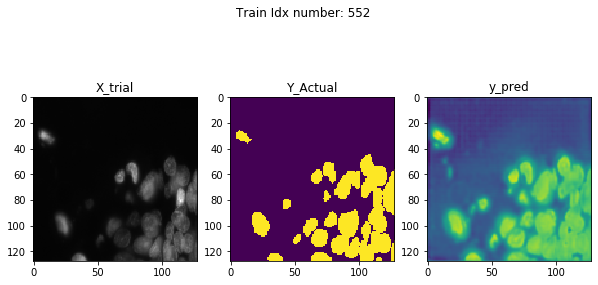

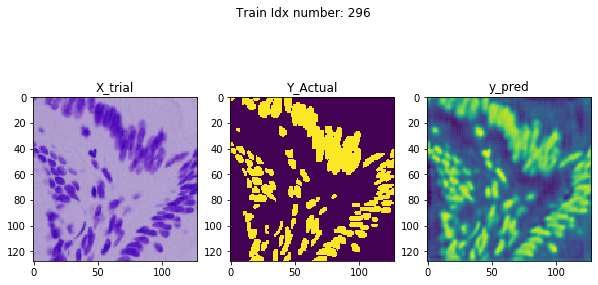

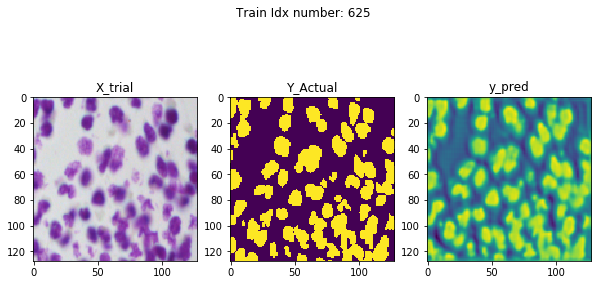

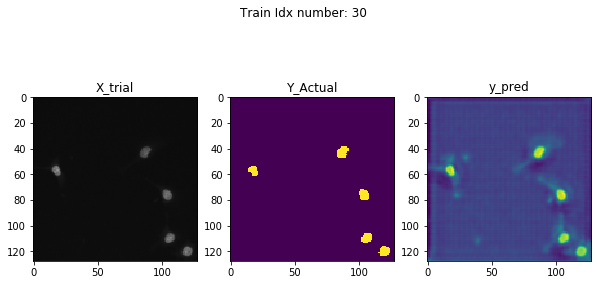

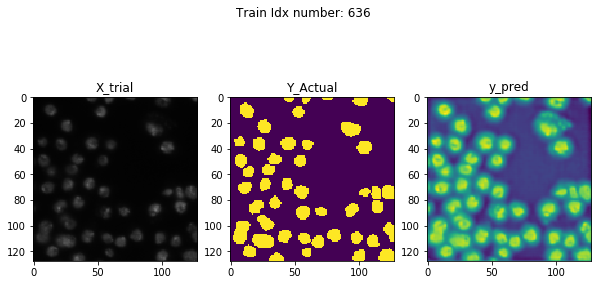

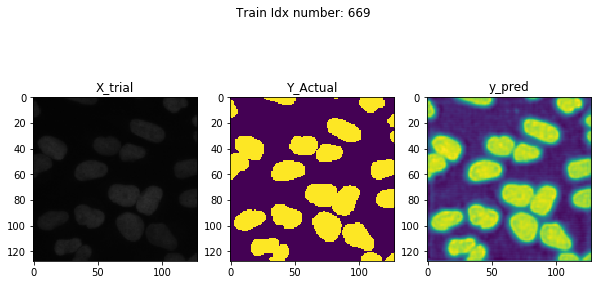

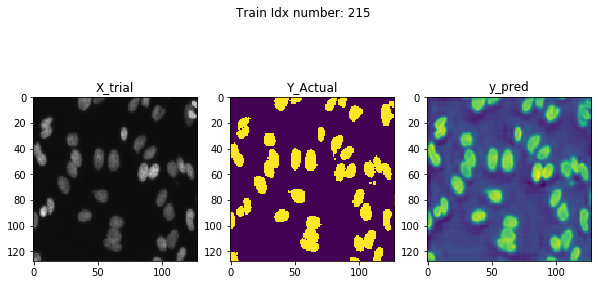

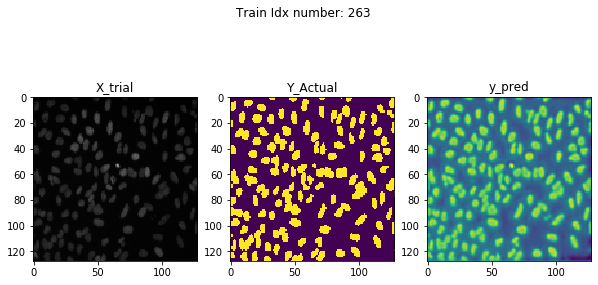

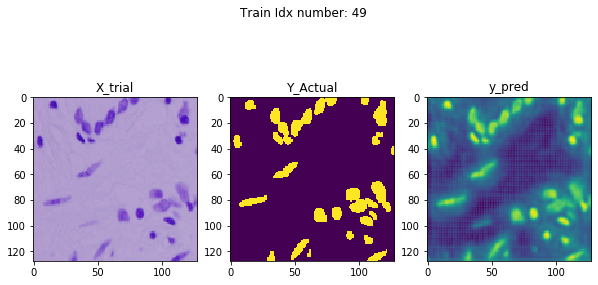

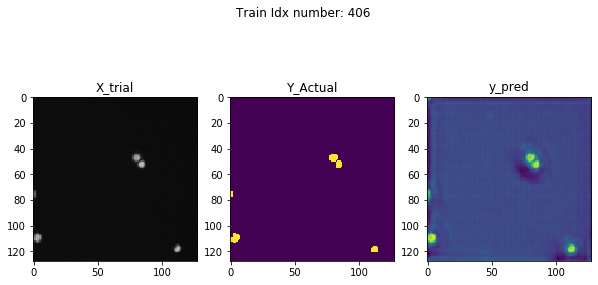

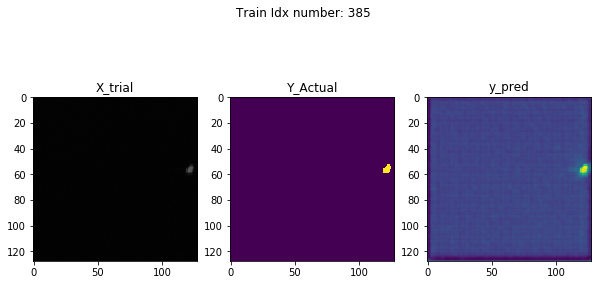

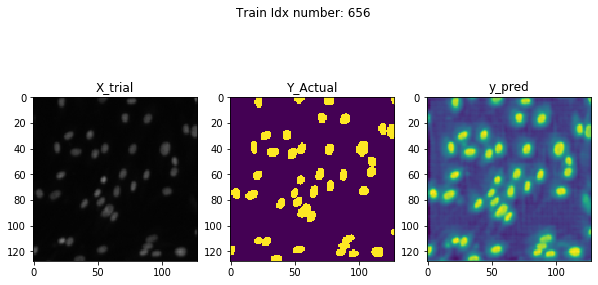

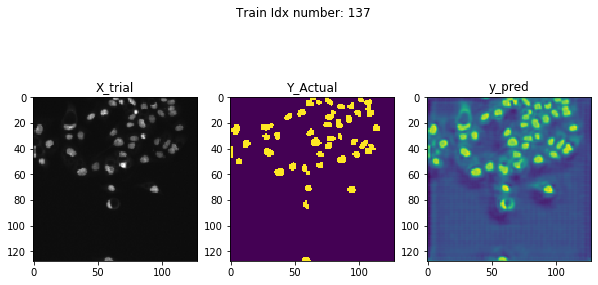

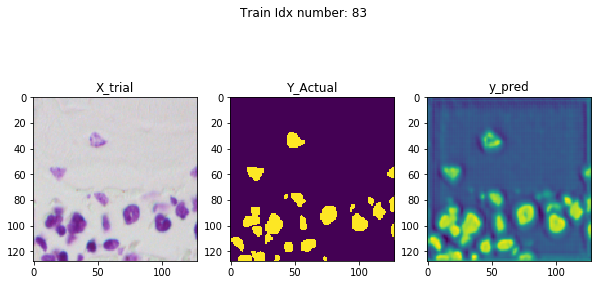

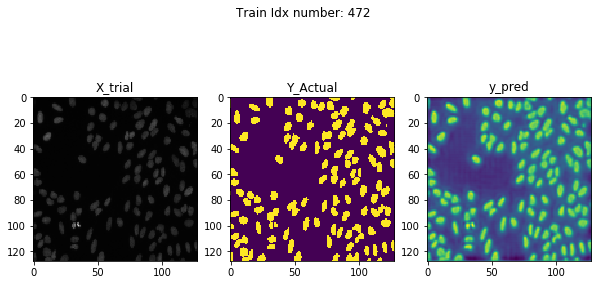

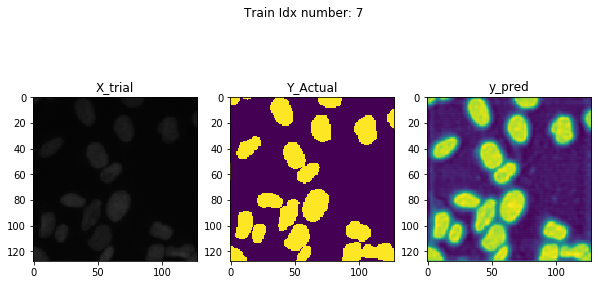

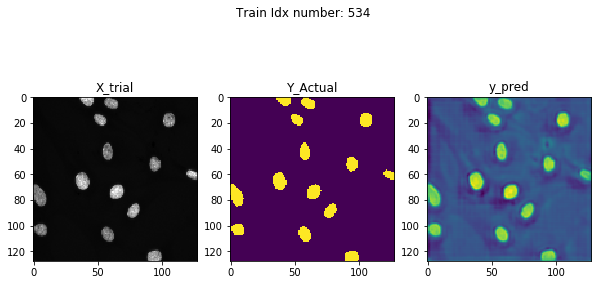

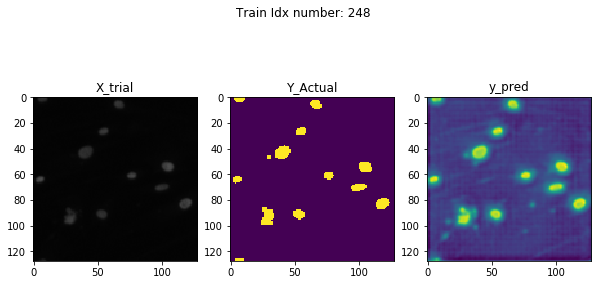

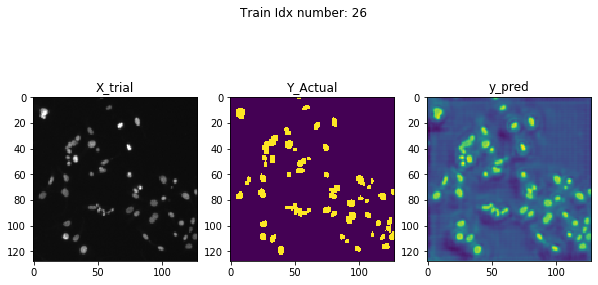

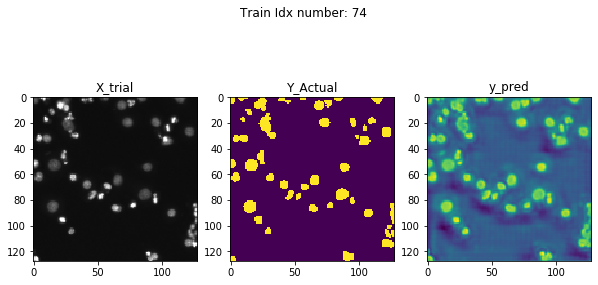

In [40]:
def show_Train_images(idx_array):
    
    for idx in idx_array:
        
        X_trial = np.expand_dims(X_Train_full[idx],0)
#         print(X_trial.shape)
        y_pred = model.predict(X_trial)
#         print(y_pred.shape)
        # print(y_pred)

        plt.figure(figsize=(10,5))
        plt.subplot(1,3,1)
        plt.imshow(X_trial[0,:,:,:3])
        plt.title('X_trial')

        plt.subplot(1,3,2)
        plt.imshow(Y_Train_full[idx,:,:,0])
        plt.title('Y_Actual')

        plt.subplot(1,3,3)
        plt.imshow(y_pred[0,:,:,0])
        plt.title('y_pred')
        
        plt.suptitle("Train Idx number: {}".format(idx))


import random        
seed = 30
random.seed(seed)
idx_array = random.sample(range(num_train_all),20)
show_Train_images(idx_array)


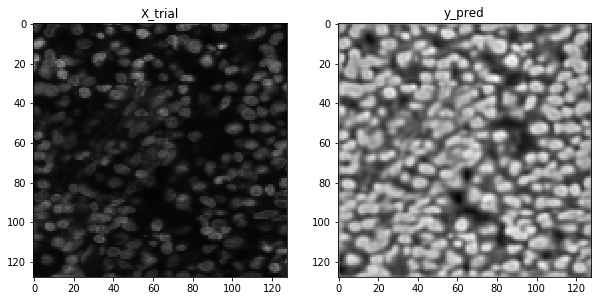

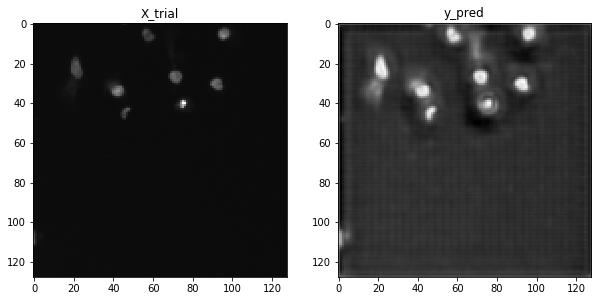

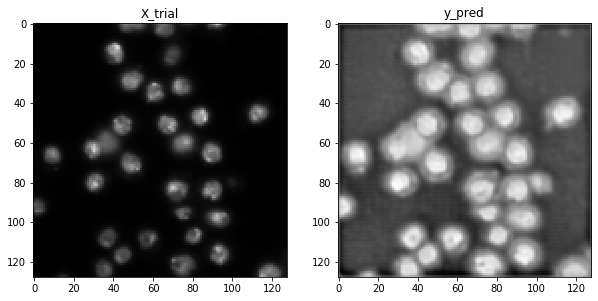

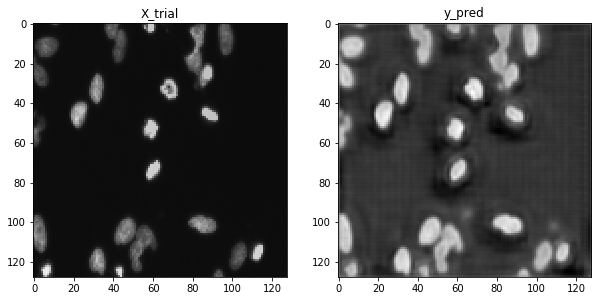

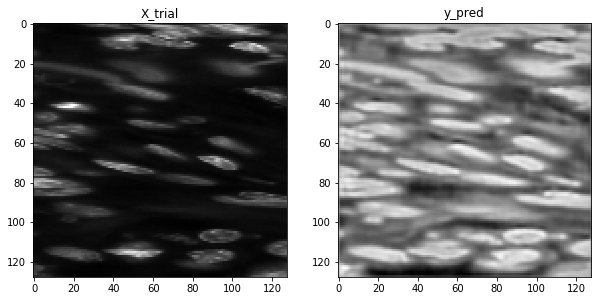

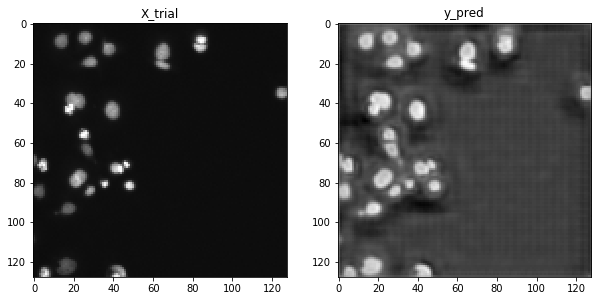

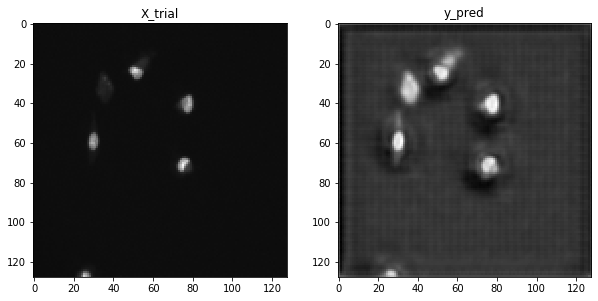

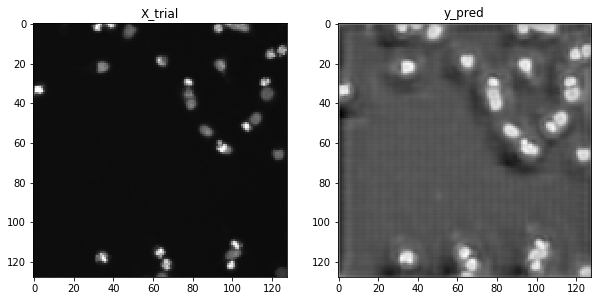

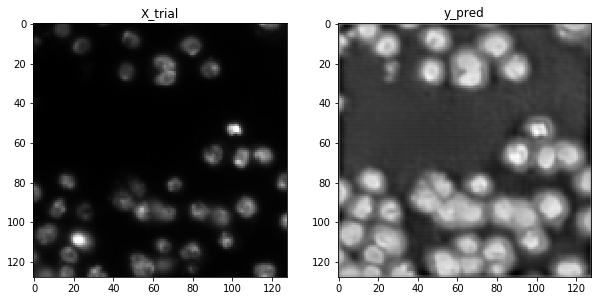

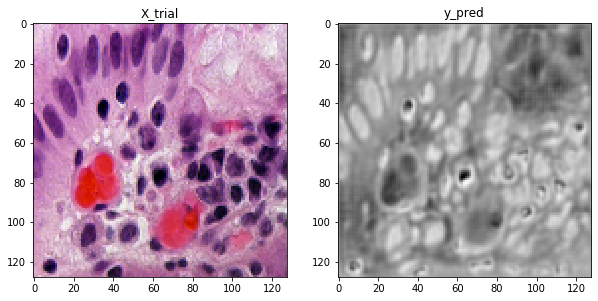

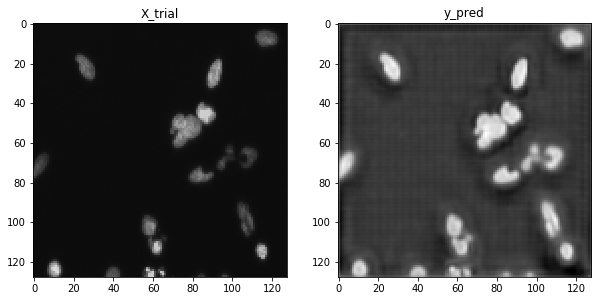

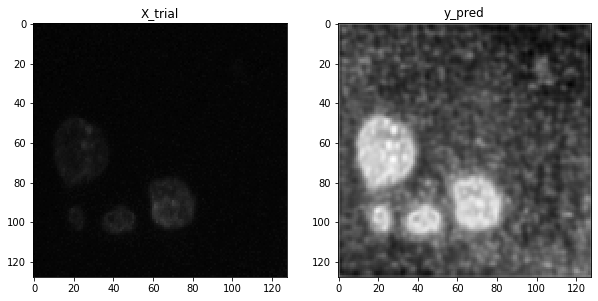

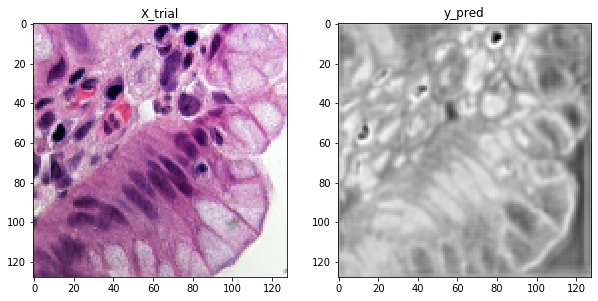

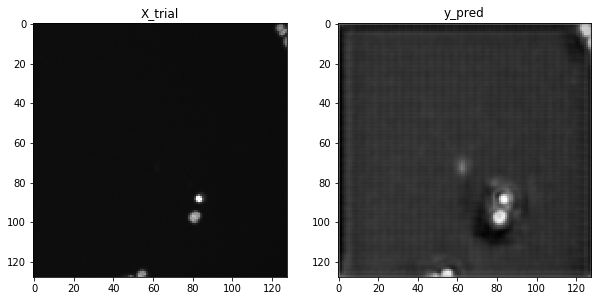

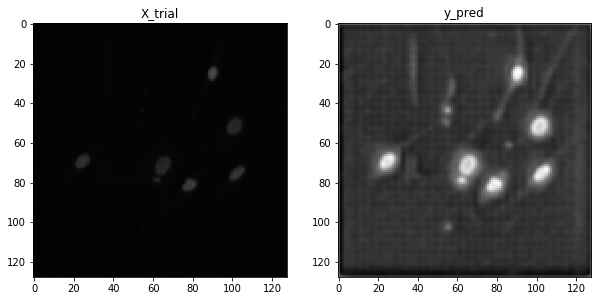

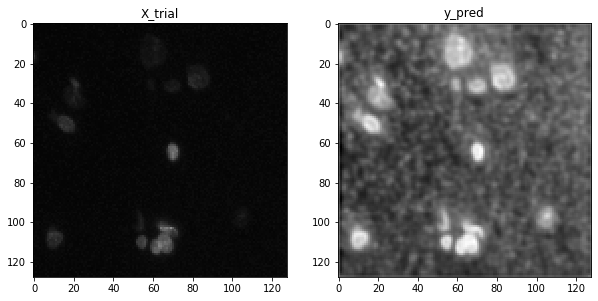

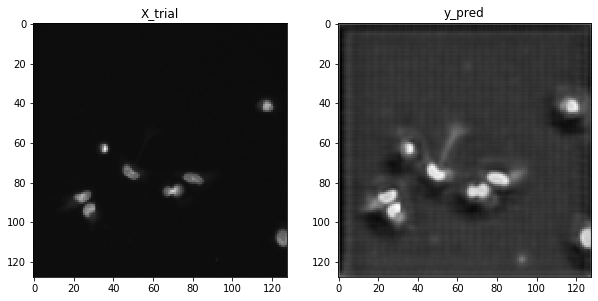

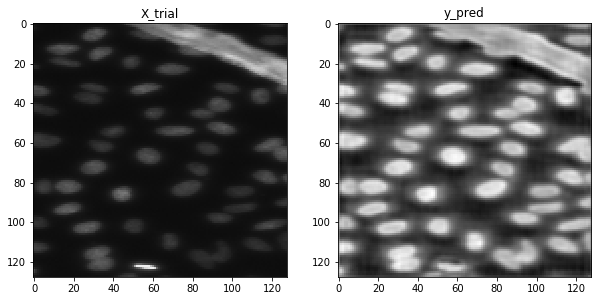

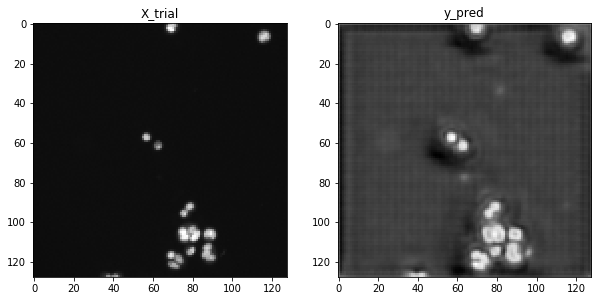

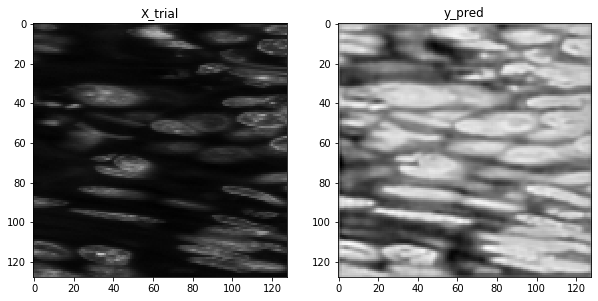

In [41]:
def show_test_predictions(idx_array):
    for idx in idx_array:
        
        X_trial = np.expand_dims(X_Test[idx],0)
        #         print(X_trial.shape)
        y_pred = model.predict(X_trial)
        #         print(y_pred.shape)
        # print(y_pred)

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(X_trial[0,:,:,:3])
        plt.title('X_trial')

        plt.subplot(1,2,2)
        plt.imshow(y_pred[0,:,:,0],cmap='gray')
        plt.title('y_pred')


seed = 30
random.seed(seed)
idx_array = random.sample(range(num_test_all),20)
show_test_predictions(idx_array)


